In [3]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import HdpModel

from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import itertools

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from ipywidgets import interact

import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import enchant
pd.set_option('display.max_rows', 500)

/Users/balaji/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/balaji/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [4]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

manualtag=pd.read_csv(Path+'SamplesManualTagger.csv')
varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

dbdf=pd.read_csv(Path+'Report_WEPCADBScanFindingsKMeansV3.csv')

In [5]:
## Only keeping noun and adjective

df.PreProcessedDescription=df.PreProcessedDescription.apply(lambda x : ' '.join([i for i,pos in TextBlob(x).tags if pos in ['NN','JJ']]))

In [6]:
manualstopwords=['research','group','subject','process','development','analysis','model','different','new','process','study','change','system','approach', 'phase', 'high', 'develop', 'allow','investigation','property','interaction','university', 'device', 'institute', 'researcher', 'science', 'fund', 'facility', 'coordination', 'cooperation']

In [7]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varclusterall=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')
newstopwords=varclusterall[(varclusterall.cluster_name=='General') | (varclusterall.cluster_name=='Text & Publish') ].Variable.tolist()+manualstopwords
#.sort_values(by='RS_Ratio')

In [8]:
df.PreProcessedDescription=[' '.join([words for words in abstract.split() if(not words in newstopwords)]) for abstract in df.PreProcessedDescription ]

### Preprocessing 

In [9]:
# TF IDF Conversion

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
review_vectors = vectorizer.fit_transform(df["PreProcessedDescription"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

features_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
merged_data=pd.concat([df,features_df], axis=1,ignore_index=False)

#wordslist=merged_data.columns.tolist()[len(df.columns)+6:]

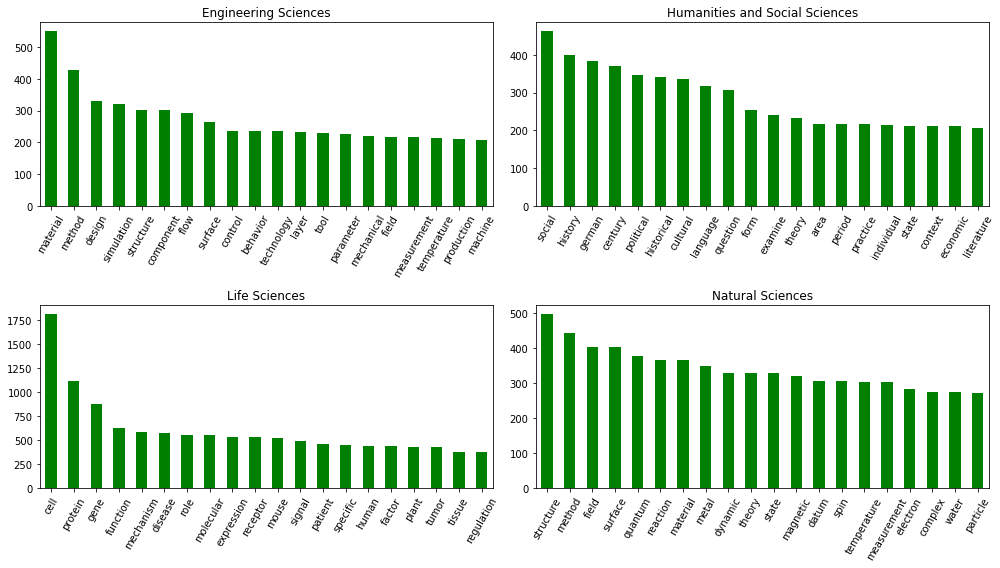

In [10]:
wordslist=merged_data.columns.tolist()[len(df.columns)+2:]

plt.subplots(figsize=(14,8)) 
i=1
categories=[]
category_words=[]

for cat,bucket in merged_data.groupby('Category'):
    
    plt.subplot(2,2,i)
    bucket[wordslist].sum().sort_values(ascending=False).head(20).plot(kind='bar',color='green')
    plt.title(cat)
    plt.xticks(rotation=60)
    i=i+1
    plt.tight_layout()
    categories.append(cat)
    category_words.append( ' '.join(bucket[wordslist].sum().sort_values(ascending=False).head(50).index.tolist()))

CategoryImpoWords=pd.DataFrame({'Category':categories,'Words':category_words})

In [11]:
CategoryImpoWords.Words.tolist()

['material method design simulation structure component flow surface control behavior technology layer tool parameter mechanical field measurement temperature production machine influence datum particle test order problem use stress possible numerical experimental condition increase load alloy optimization technique dynamic network quality large area form sensor element concept measure performance algorithm low',
 'social history german century political historical cultural language question form examine theory area period practice individual state context economic literature hand law focus policy early european concept literary knowledge germany central perspective modern basis religious society culture medium important relationship international discourse national public life collection order manuscript market datum',
 'cell protein gene function mechanism disease role molecular expression receptor mouse signal patient specific human factor plant tumor tissue regulation response acti

In [12]:
CategoryImpoWords.loc[CategoryImpoWords.Category=='Engineering Sciences', 'Words']='engineer method simulation component flow surface behavior technology tool parameter mechanical field measurement temperature production machine particle numerical optimization technique sensor element measure performance algorithm knowledge'
CategoryImpoWords.loc[CategoryImpoWords.Category=='Humanities and Social Sciences', 'Words']='humanities social history country century political cultural language economic literature law early policy european literary knowledge religious society culture national manuscript market'
CategoryImpoWords.loc[CategoryImpoWords.Category=='Life Sciences', 'Words']='biology life cell protein gene disease molecular receptor mouse signal patient human factor plant tumor tissue membrane immune genetic cellular animal specie dna vivo clinical infection brain therapy inflammatory therapeutic'
CategoryImpoWords.loc[CategoryImpoWords.Category=='Natural Sciences', 'Words']='natural field surface quantum metal theory magnetic spin temperature measurement electron water complex particle energy compound molecule chemical electronic synthesis transition molecular optical climate spectroscopy resolution organic gas polymer sediment'

In [13]:
## Repeated words in category

word=[]
for x in [cc.split() for cc in CategoryImpoWords.Words]:
    word.extend(x)
pd.Series(word).value_counts().sort_values(ascending=False).head(16)#.index.tolist()

temperature     2
particle        2
surface         2
measurement     2
molecular       2
knowledge       2
field           2
cellular        1
numerical       1
complex         1
behavior        1
early           1
optimization    1
transition      1
literary        1
performance     1
dtype: int64

#### 1.1 Word Embedding

In [14]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=3, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list        
        
## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [15]:
## creating a tagged document
#DescDict=make_bigram([[x for x in str(i).split()] for i in df.PreProcessedDescription])
DescDict=[[x for x in str(i).split()] for i in df.PreProcessedDescription]


#tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [16]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.Word2Vec(DescDict,size=50, min_count=1, alpha = 0.02, sg=0, seed=42, workers=4)

#### Hyper parameter ####
print(str(datetime.datetime.now()),'Completed')

2020-03-09 17:17:08.840374 Started
2020-03-09 17:17:40.186258 Completed


In [17]:
## Validating the model response for random words 

modelchecked=model
target_word='biology'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=10), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'biology' model: Word2Vec(vocab=114576, size=50, alpha=0.02) similar words:
    1. 0.88 'biochemistry'
    2. 0.82 'biophysic'
    3. 0.81 'microbiology'
    4. 0.80 'biotechnology'
    5. 0.78 'biologist'
    6. 0.78 'fossilize'
    7. 0.77 'bioscience'
    8. 0.77 'virology'
    9. 0.74 'immunology'
    10. 0.74 'biomedical'


In [18]:
modelchecked.similarity('country','german')

/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.75834686

In [19]:
###############################
#### similarity functions #####
###############################

def map_word_frequency(document):
    return Counter(itertools.chain(*document))
    
def get_sif_feature_vectors(sentence1, sentence2, word_emb_model=modelchecked):
    sentence1 = [token for token in sentence1.split() if token in word_emb_model.wv.vocab]
    sentence2 = [token for token in sentence2.split() if token in word_emb_model.wv.vocab]
    word_counts = map_word_frequency((sentence1 + sentence2))
    embedding_size = 50 # size of vectore in word embeddings
    a = 0.0001
    sentence_set=[]
    for sentence in [sentence1, sentence2]:
        vs = np.zeros(embedding_size)
        sentence_length = len(sentence)
        for word in sentence:
            a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, word_emb_model.wv[word])) # vs += sif * word_vector
        vs = np.divide(vs, sentence_length) # weighted average
        sentence_set.append(vs)
    return sentence_set

def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

def similarity_scores(sentence1, sentence2, n=10):
    sentence1=sentence1.replace(',','')
    sentence2=sentence2.replace(',','')
    features=get_sif_feature_vectors(sentence1, sentence2)
    return get_cosine_similarity(features[0][:n],features[1][:n])

### Direct Comparision

In [20]:
direct_score=[]
size=len(df.PreProcessedDescription)
with tqdm(total=size) as bar:
    for i in range(len(df.PreProcessedDescription)):
        topicWord=df.loc[i].PreProcessedDescription
        CatWords=CategoryImpoWords[CategoryImpoWords.Category==df.loc[i].Category].Words.values[0]
        direct_score.append(similarity_scores(topicWord, CatWords,50))
        bar.update(1)

100%|██████████| 51033/51033 [02:37<00:00, 323.72it/s]


In [21]:
df['direct_score']=direct_score

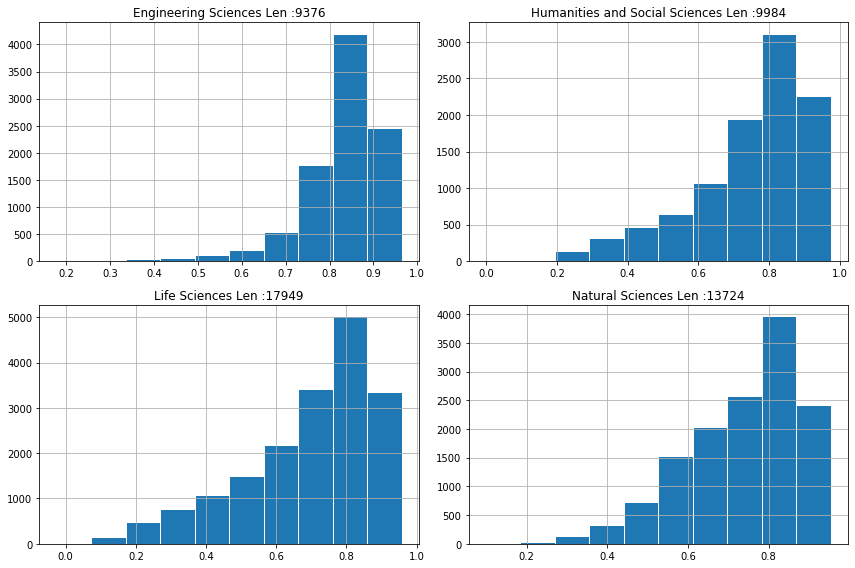

In [22]:
i=1
plt.figure(figsize=(12, 8))
for cc,w in df.groupby(['Category']):
    plt.subplot(2,2,i)
    w['direct_score'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

In [23]:
df['ProjectURL']=df.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)
df1=df.merge(dbdf[['ProjectURL','interdiscipilinary']],how='left', left_on='ProjectURL', right_on='ProjectURL')

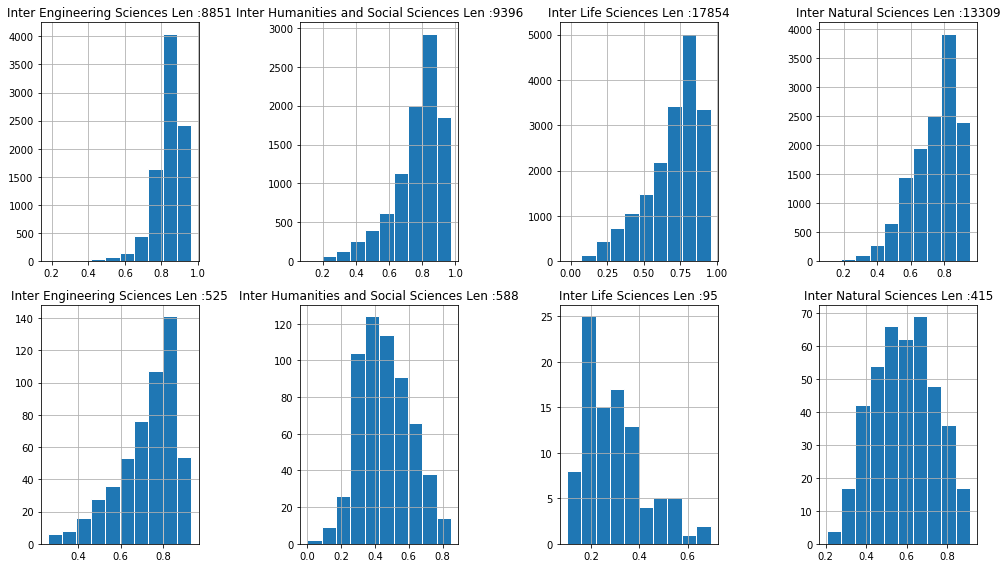

In [24]:
i=1
plt.figure(figsize=(14, 8))
for (intt,cc),w in df1.groupby(['interdiscipilinary','Category']):
    plt.subplot(2,4,i)
    w['direct_score'].hist( edgecolor='white', linewidth=1)    
    plt.title('Inter '+str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

In [25]:
#limit_cat={'Natural Sciences':.47, 'Humanities and Social Sciences':.5,'Engineering Sciences':0.7, 'Life Sciences':.3}
limit_cat={'Natural Sciences':.5, 'Humanities and Social Sciences':.58,'Engineering Sciences':0.77, 'Life Sciences':.33}


df1['new_interdiscipilinary']=False

df1.loc[(df.Category=='Natural Sciences') & (limit_cat['Natural Sciences'] > df1.direct_score)
| (df1.Category=='Humanities and Social Sciences') & (limit_cat['Humanities and Social Sciences'] > df1.direct_score)
| (df1.Category=='Engineering Sciences') & (limit_cat['Engineering Sciences'] > df1.direct_score)
| (df1.Category=='Life Sciences') & (limit_cat['Life Sciences'] > df1.direct_score),'new_interdiscipilinary']=True

#merged_df1[(merged_df1['new_interdiscipilinary'])].Category.value_counts()

In [26]:
df1[(df1['new_interdiscipilinary'])].Category.value_counts()

Engineering Sciences              1630
Humanities and Social Sciences    1563
Life Sciences                     1083
Natural Sciences                   928
Name: Category, dtype: int64

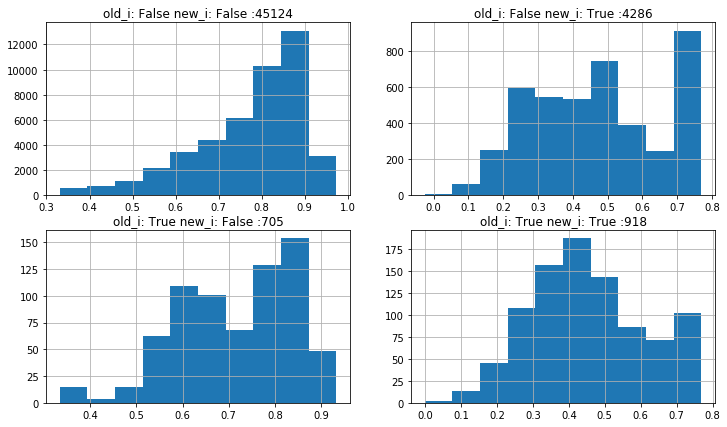

In [27]:
j=1
plt.figure(figsize=(12, 7))
for (old_i,new_i),w in df1.groupby(['interdiscipilinary','new_interdiscipilinary']):
    plt.subplot(2,2,j)
    w['direct_score'].hist()
    plt.title('old_i: '+str(old_i)+' new_i: '+str(new_i)+' :'+str(len(w)) )
    j=j+1

In [28]:
df1[(df1['new_interdiscipilinary']) & (df1['interdiscipilinary']==False) & (df1['Category']=='Life Sciences')].head(10)

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,File_Categories,Category,direct_score,ProjectURL,interdiscipilinary,new_interdiscipilinary
86,GRK 642:&nbsp; Valuation and Management of Bio...,/gepris/projekt/273169,2000,2003,"Agriculture, Forestry and Veterinary Medicine",Georg-August-Universität Göttingen,The goal of the interdisciplinary research tra...,The goal of the interdisciplinary research tra...,GRK 642:&nbsp; Valuation and Management of Bio...,interdisciplinary identify problem perspective...,"Agriculture, Forestry and Veterinary Medicine",Life Sciences,0.218981,https://gepris.dfg.de/gepris/projekt/273169,False,True
119,GRK 793:&nbsp; Epidemiology of Communicable an...,/gepris/projekt/273475,2002,2011,Medicine,Ruprecht-Karls-Universität Heidelberg,Large epidemiological studies which have been ...,Large epidemiological studies which have been ...,GRK 793:&nbsp; Epidemiology of Communicable an...,large epidemiological carry design population ...,Medicine,Life Sciences,0.299170,https://gepris.dfg.de/gepris/projekt/273475,False,True
155,GRK 1070:&nbsp; Modelling Material Flows and P...,/gepris/projekt/425187,2004,2013,"Agriculture, Forestry and Veterinary Medicine",Universität Hohenheim,Agricultural food production in the North Chin...,Agricultural food production in the North Chin...,GRK 1070:&nbsp; Modelling Material Flows and P...,agricultural food production north china plain...,"Agriculture, Forestry and Veterinary Medicine",Life Sciences,0.184351,https://gepris.dfg.de/gepris/projekt/425187,False,True
157,GRK 1086:&nbsp; The Role of Biodiversity für B...,/gepris/projekt/446768,2005,2014,Plant Sciences,Georg-August-Universität Göttingen,The relationship between biodiversity and prod...,The relationship between biodiversity and prod...,GRK 1086:&nbsp; The Role of Biodiversity für B...,relationship biodiversity productivity biogeoc...,Plant Sciences,Life Sciences,0.307836,https://gepris.dfg.de/gepris/projekt/446768,False,True
242,Rechnerische Simulation von Operationsverfahre...,/gepris/projekt/5077364,1998,2006,Traumatology and Orthopaedics,Charité Universitätsklinikum,"(Wortlaut des Antrages)Ein detailliertes, drei...","(Full text of the proposal) A detailed, three-...",Computational simulation of surgical procedure...,proposal detailed dimensional linear lumbar sp...,Traumatology and Orthopaedics,Life Sciences,0.282884,https://gepris.dfg.de/gepris/projekt/5077364,False,True
259,Betriebsaufgabe und Rückzugsstrategien in der ...,/gepris/projekt/5079236,1997,2002,Agricultural Economics and Sociology,Humboldt-Universität zu Berlin,Für die modellexogene Identifizierung von Rück...,For the model-exogenous identification of with...,Operating task and withdrawal strategies in ag...,exogenous identification withdrawal strategy d...,Agricultural Economics and Sociology,Life Sciences,0.251029,https://gepris.dfg.de/gepris/projekt/5079236,False,True
263,Untersuchungen zur Biogeographie und Biodivers...,/gepris/projekt/5079644,1997,2001,Plant Physiology,Universität Zürich,Die Anden gehören zu den botanisch artenreichs...,The Andes are among the most botanically diver...,Studies on the biogeography and biodiversity o...,diverse area world know spatial distribution d...,Plant Physiology,Life Sciences,0.257403,https://gepris.dfg.de/gepris/projekt/5079644,False,True
322,Multiskalige Analyse der Ortsteingenese am Bei...,/gepris/projekt/5085426,1998,2003,Soil Sciences,Universität Hohenheim,Im Rahmen des Forschungsvorhabens 'Multiskalig...,In the framework of the research project 'Mult...,Multiscale analysis of the Ortsteingenese usin...,framework multiscale local soil engineering ex...,Soil Sciences,Life Sciences,0.170998,https://gepris.dfg.de/gepris/projekt/5085426,False,True
337,Zentralprojekt,/gepris/projekt/5086502,1998,2005,Cognitive Neuroscience,Carl von Ossietzky Universität Oldenburg,Zur Förderung der Zusammenarbeit der Projekte ...,In order to promote t

In [29]:
df1[(df1['new_interdiscipilinary']) & (df1['interdiscipilinary']==False) & (df1['Category']=='Life Sciences')].head(10).Translates.tolist()

["The goal of the interdisciplinary research training group is to identify the problems and perspectives of implementation of the biodiversity treaty. The field of research concentrates on areas of conservancy noted in Art. 8 of the treaty. The main starting point is the so-called 'reconciliation of interests' problem describing the phenomenon that costs and benefits for maintaining biodiversity are distributed unequally. Thus, it is necessary for the respective instruments to be developed for just compensation. This dilemma defines the interdisciplinary problem for the research training group and implies its primarily social science orientation.The program of study is tailored to a large degree to the demands of the above mentioned complex of topics. In addition to expanding the intradisciplinary competence of the students, it is especially important to foster the essential to work interdisciplinarily in the scientific and politically relevant area of sustainable development. The comm

In [30]:
df1[(df1['new_interdiscipilinary']) & (df1['interdiscipilinary']==False) & (df1['Category']=='Life Sciences')].head(10).PreProcessedDescription.tolist()

['interdisciplinary identify problem perspective implementation biodiversity treaty field concentrate area conservancy art treaty main point reconciliation interest problem describe phenomenon cost benefit biodiversity distribute respective compensation dilemma interdisciplinary problem training social orientation tailor large degree demand mention complex addition intradisciplinary competence student important foster essential relevant area sustainable commitment treaty educate expert area fulfil form instruction emphasis place element interdisciplinary problem solve train',
 'large epidemiological carry design population common platform graduation team interdisciplinary',
 'agricultural food production north china plain characterise level production intensity crop rotation yield sustainability account chinaâ agriculture productivity order meet population rise standard consequence agricultural production china environmental problem water availability air water pollution soil degradati

In [31]:
topicWord='biological basis central nervous university institute neurobiology medical faculty otto von guericke university important aspect educational bridge gap clinical basic neuroscience training excellent opportunity young investigator postgraduate level background interest biomedical relate aspect brain disorder broad spectrum integrative combine state art technique interdisciplinary educational lead phd degree md phd successful individual carreer track field brain educate aspect life science magdeburg neuroscience center attract considerable extramural superb facility molecular biochemical modern invasive brain imaging technique student medical faculty leibniz institute neurobiology researcher biology psychology engineering chemistry contribute magdeburgs interdisciplinary neuroscience profile consequence joint effort otto guericke university neuroscience lead diploma master degree science'
for j in CategoryImpoWords.Category:
    CatWords=CategoryImpoWords[CategoryImpoWords.Category==j].Words.values[0]
    score=similarity_scores(topicWord, CatWords,30)
    print(j, score)

Engineering Sciences 0.4984358164193121
Humanities and Social Sciences 0.5248409270932137
Life Sciences 0.5192615431187392
Natural Sciences 0.419950308204428


## Building LDA

In [32]:
###############################
#### LDA Topic Functions #####
###############################

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

#def make_bigram(inputlist):
#    bigram = Phrases(inputlist, min_count=1, threshold=1,delimiter=b' ')
#    bigram_phraser = Phraser(bigram)
#    new_list=[]
#    for sent in inputlist:
#        new_list.append(bigram_phraser[sent])
#    return new_list

def buildLDA(processed_docs, ip_num_topics=4):
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=1000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    
    return dictionary,bow_corpus,corpus_tfidf#, lda_model_tfidf

def LDAtopicSummary(model, displaysubplot=[2,2]):
    for idx, topic in model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords',"Text"]
    return(sent_topics_df)

def build_topics_sentences(ldamodel, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()
    out_df=[]
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel.get_document_topics(corpus)):
        row = sorted(row_list, key=lambda x: x[1], reverse=True)
        inn_df=[]
        for num,prob in row:
            inn_df.append(num)
            inn_df.append(prob)
        out_df.append(np.array(inn_df))
            
    return out_df

In [33]:
#docs=make_bigram(df["PreProcessedDescription"].map(preprocess))
docs=df["PreProcessedDescription"].map(preprocess)
print(str(len(docs))+' docs in input')
dictionary,bow_corpus,corpus_tfidf =buildLDA(docs)

51033 docs in input


In [34]:
#lda_model_tfidf = HdpModel(corpus_tfidf, id2word=dictionary,  random_state=42)
ip_num_topics=35
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, 
                                                 eta=[0.001]*len(dictionary.keys()), alpha =.001*ip_num_topics, random_state=42)

In [35]:
lda_model_tfidf.print_topics()

[(12,
  '0.549*"migration" + 0.004*"behavior" + 0.004*"behaviour" + 0.003*"signal" + 0.003*"north" + 0.003*"longitudinal" + 0.003*"gene" + 0.003*"population" + 0.003*"degree" + 0.002*"simple"'),
 (19,
  '0.113*"infrastructure" + 0.037*"critical" + 0.032*"microscope" + 0.025*"unit" + 0.025*"concern" + 0.015*"force" + 0.012*"systematic" + 0.007*"utilize" + 0.007*"microscopy" + 0.006*"reflect"'),
 (1,
  '0.289*"landscape" + 0.007*"land" + 0.007*"identity" + 0.007*"block" + 0.006*"discourse" + 0.006*"cultural" + 0.005*"building" + 0.005*"construction" + 0.004*"social" + 0.004*"architecture"'),
 (0,
  '0.022*"quantum" + 0.021*"spin" + 0.018*"magnetic" + 0.013*"electron" + 0.013*"electronic" + 0.012*"optical" + 0.009*"semiconductor" + 0.009*"spectroscopy" + 0.009*"excitation" + 0.008*"charge"'),
 (9,
  '0.035*"reaction" + 0.021*"catalyst" + 0.020*"metal" + 0.020*"compound" + 0.020*"synthesis" + 0.014*"catalytic" + 0.013*"chemistry" + 0.013*"ligand" + 0.012*"chemical" + 0.011*"bond"'),
 (15,


In [36]:
#pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary=lda_model_tfidf.id2word)

In [37]:
topic_words=[]
for i in range(ip_num_topics):
    topic_words.append(", ".join([word for (word, value) in lda_model_tfidf.show_topic(i)]))

TopicDesc=pd.DataFrame({'TopicNo':range(ip_num_topics), 'topic_words':topic_words})

TopicDesc['Category_1']=''
TopicDesc['Category_2']=''

for i in range(ip_num_topics):
    topicWord=TopicDesc[TopicDesc.TopicNo==i].topic_words.values[0].replace(',','')
    max_1=0
    max_2=0
    scores=[]
    
    for j in CategoryImpoWords.Category.tolist():
        CatWords=CategoryImpoWords[CategoryImpoWords.Category==j].Words.values[0]
        score=similarity_scores(topicWord, CatWords,30)
        TopicDesc.loc[TopicDesc.TopicNo==i, j]=score
        scores.append(score)
    if(pd.Series(scores).sort_values(ascending=False).head(1).values[0]>0.5):
        TopicDesc.loc[TopicDesc.TopicNo==i, 'Category_1']=CategoryImpoWords.Category.tolist()[pd.Series(scores).sort_values(ascending=False).head(1).index[0]]
        if(round(pd.Series(scores).sort_values(ascending=False).values[0]-pd.Series(scores).sort_values(ascending=False).values[1],2)<.05):
            TopicDesc.loc[TopicDesc.TopicNo==i, 'Category_2']=CategoryImpoWords.Category.tolist()[pd.Series(scores).sort_values(ascending=False).head(2).index[1]]

TopicDesc

,TopicNo,topic_words,Category_1,Category_2,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
0,0,"quantum, spin, magnetic, electron, electronic,...",Natural Sciences,,0.656835,0.071684,0.208217,0.890524
1,1,"landscape, land, identity, block, discourse, c...",Humanities and Social Sciences,,0.341917,0.841118,0.192162,0.317078
2,2,"pulse, laser, array, collaborative, double, op...",Engineering Sciences,Natural Sciences,0.704652,0.079206,0.282694,0.679321
3,3,"enzyme, acid, gene, metabolism, plant, transcr...",Life Sciences,,0.124826,0.150717,0.728235,0.291236
4,4,"brain, cognitive, memory, visual, neural, stim...",Life Sciences,,0.169844,0.058626,0.628935,-0.027408
5,5,"mouse, disease, receptor, inflammatory, inflam...",Life Sciences,,0.032967,-0.109147,0.857594,-0.029880
6,6,"channel, receptor, voltage, muscle, release, i...",Life Sciences,,0.169901,-0.305186,0.674759,0.221046
7,7,"mass, beam, image, resolution, motion, measure...",Engineering Sciences,Natural Sciences,0.630558,0.036044,0.198675,0.626204
8,8,"gene, expression, mutant, plant, mutation, tra...",Life Sciences,,0.139527,0.197025,0.742118,0.026179
9,9,"reaction, catalyst, metal, compound, synthesis...",Natural Sciences,,0.323992,0.096443,0.118024,0.801142


In [38]:
TopicDesc.topic_words.tolist()

['quantum, spin, magnetic, electron, electronic, optical, semiconductor, spectroscopy, excitation, charge',
 'landscape, land, identity, block, discourse, cultural, building, construction, social, architecture',
 'pulse, laser, array, collaborative, double, optical, short, frequency, excitation, radiation',
 'enzyme, acid, gene, metabolism, plant, transcriptional, substrate, genome, metabolic, amino',
 'brain, cognitive, memory, visual, neural, stimulus, neuronal, neuron, behavioral, motor',
 'mouse, disease, receptor, inflammatory, inflammation, immune, activation, signal, heart, expression',
 'channel, receptor, voltage, muscle, release, intracellular, membrane, signal, dependent, ligand',
 'mass, beam, image, resolution, motion, measurement, quantification, sample, spectra, spectrometry',
 'gene, expression, mutant, plant, mutation, transcription, regulation, genetic, signal, genome',
 'reaction, catalyst, metal, compound, synthesis, catalytic, chemistry, ligand, chemical, bond',
 '

In [282]:
TopicDesc[TopicDesc['Category_1']=='']

,TopicNo,topic_words,Category_1,Category_2,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
15,15,"specie, evolution, evolutionary, genetic, morp...",,,0.260913,0.410928,0.307983,0.357209
21,21,"plant, specie, host, diversity, community, eco...",,,0.339738,0.486745,0.381229,0.437387
28,28,"channel, neuron, plasticity, neuronal, voltage...",,,0.445364,-0.010336,0.478491,0.177681


In [39]:
TopicDesc.loc[1,'Category_1']='Natural Sciences'
TopicDesc.loc[2,'Category_1']='Other'
TopicDesc.loc[15,'Category_1']='Life Sciences'
TopicDesc.loc[21,'Category_1']='Natural Sciences'
TopicDesc.loc[28,'Category_1']='Life Sciences'


#TopicDesc

In [40]:
TopicDesc[TopicDesc['Category_1']==''].topic_words.tolist()

['soil, plant, root, ecosystem, microbial, community, water, nutrient, carbon, specie',
 'specie, evolution, population, evolutionary, genetic, diversity, genome, morphological, plant, ecological']

In [41]:
Categories=[]
Topic_ids=[]
words=[]
probs=[]

topic_words=[]
for i in range(ip_num_topics):
    for (word, value) in lda_model_tfidf.show_topic(i):
        Topic_ids.append(i)
        Categories.append(TopicDesc.loc[(TopicDesc.TopicNo==i),'Category_1'].values[0])
        words.append(word)
        probs.append(value)
LDAWordsCloud=pd.DataFrame({'Category':Categories,'Topic':Topic_ids, 'words':words,'probs':probs })
LDAWordsCloud.to_csv(Path+'LDA_WordsCloud_Exp1.csv', index=False)

In [285]:
for c1 in CategoryImpoWords.Category:
    CategoryImpoWords[c1]=0
    for c2 in CategoryImpoWords.Category:
         CategoryImpoWords.loc[CategoryImpoWords.Category==c2,c1]=similarity_scores(CategoryImpoWords.loc[CategoryImpoWords.Category==c1, 'Words'].values[0],  CategoryImpoWords.loc[CategoryImpoWords.Category==c2, 'Words'].values[0]
                                                                                    ,50)
CategoryImpoWords

,Category,Words,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
0,Engineering Sciences,engineer method simulation component flow surf...,1.000000,0.153017,0.229542,0.721981
1,Humanities and Social Sciences,humanities social history country century poli...,0.153017,1.000000,-0.007114,0.089138
2,Life Sciences,biology life cell protein gene disease molecul...,0.229542,-0.007114,1.000000,0.190112
3,Natural Sciences,natural field surface quantum metal theory mag...,0.721981,0.089138,0.190112,1.000000


In [286]:
CategoryImpoWords.Words.tolist()

['engineer method simulation component flow surface behavior technology tool parameter mechanical field measurement temperature production machine particle numerical optimization technique sensor element measure performance algorithm knowledge',
 'humanities social history country century political cultural language economic literature law early policy european literary knowledge religious society culture national manuscript market',
 'biology life cell protein gene disease molecular receptor mouse signal patient human factor plant tumor tissue membrane immune genetic cellular animal specie dna vivo clinical infection brain therapy inflammatory therapeutic',
 'natural field surface quantum metal theory magnetic spin temperature measurement electron water complex particle energy compound molecule chemical electronic synthesis transition molecular optical climate spectroscopy resolution organic gas polymer sediment']

## Finding distance for each category

In [287]:
size=len(df)

ls_expected_topic=[]
ls_expected_topic_cat=[]
ls_newwords=[]
ls_sim_score=[]

with tqdm(total=size) as bar:
    for i in range(size):
        result=lda_model_tfidf.get_document_topics(corpus_tfidf[i],per_word_topics=True)
        cids=[c_id  for (c_id,c_topic) in  result[1] if(c_topic)]
        
        if(len(result[0])>0):
            expected_topic=result[0][0][0]
            expected_topic_cat= TopicDesc.loc[TopicDesc.TopicNo==expected_topic,'Category_1'].values[0]
        else:
            expected_topic=-1
            expected_topic_cat=''
        newwords=' '.join([dictionary[i] for i in cids])
        
        ls_expected_topic.append(expected_topic)
        ls_expected_topic_cat.append(expected_topic_cat)
        ls_newwords.append(newwords)
        
        Catwords=CategoryImpoWords.loc[CategoryImpoWords.Category==df.loc[i,"Category"],'Words'].tolist()[0]   

        if((pd.isnull(newwords)==False) & (len(newwords)>=0) ):
            try:
                sim_score=similarity_scores(newwords,Catwords,20)
            except:
                #print(i,'Warning: Could not find the simlarity for -',newwords)
                pass

        
        ls_sim_score.append(sim_score)
        bar.update(1)
    
SimilarityPoints=pd.DataFrame({'Topic':ls_expected_topic, 'Top_Category':ls_expected_topic_cat,'Desc_words':ls_newwords, 'Similarity':ls_sim_score  })

100%|██████████| 51033/51033 [05:39<00:00, 150.24it/s]


In [288]:
merged_df1=pd.concat([df,SimilarityPoints],ignore_index=True, axis=1)
merged_df1.columns=df.columns.tolist()+SimilarityPoints.columns.tolist()

In [289]:
merged_df1['ProjectURL']=merged_df1.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)

merged_df1=merged_df1.merge(dbdf[['ProjectURL','interdiscipilinary']],how='left', left_on='ProjectURL', right_on='ProjectURL')

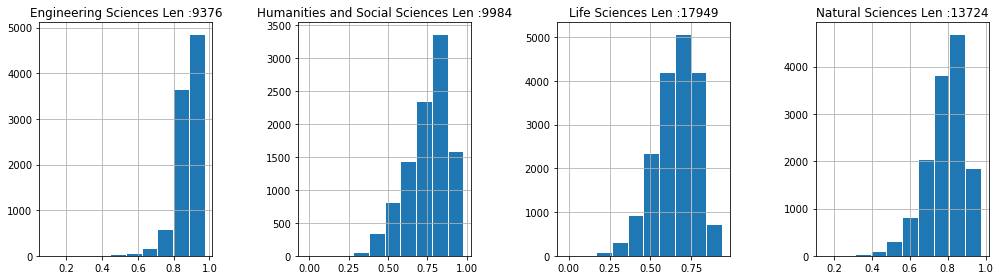

In [343]:
i=1
plt.figure(figsize=(14, 4))
for cc,w in merged_df1.groupby(['Category']):
    plt.subplot(1,4,i)
    w['Similarity'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

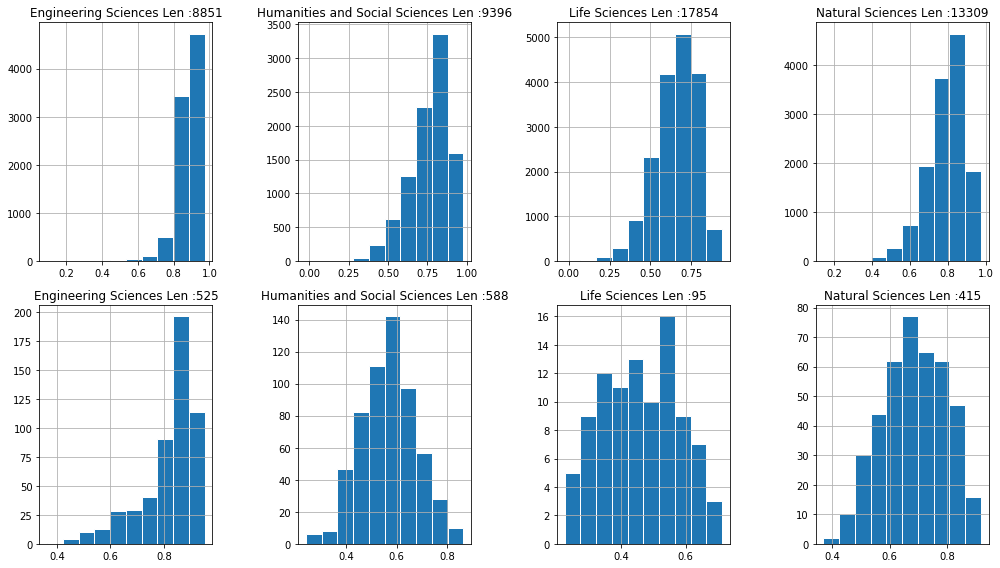

In [344]:
i=1
plt.figure(figsize=(14, 8))
for (intt,cc),w in merged_df1.groupby(['interdiscipilinary','Category']):
    plt.subplot(2,4,i)
    w['Similarity'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

In [554]:
#limit_cat={'Natural Sciences':.6, 'Humanities and Social Sciences':.55,'Engineering Sciences':0.8, 'Life Sciences':.43}
limit_cat={'Natural Sciences':.64, 'Humanities and Social Sciences':.58,'Engineering Sciences':0.815, 'Life Sciences':.45}

merged_df1['new_interdiscipilinary']=False

merged_df1.loc[(merged_df1.Category=='Natural Sciences') & (limit_cat['Natural Sciences'] > merged_df1.Similarity)
| (merged_df1.Category=='Humanities and Social Sciences') & (limit_cat['Humanities and Social Sciences'] > merged_df1.Similarity)
| (merged_df1.Category=='Engineering Sciences') & (limit_cat['Engineering Sciences'] > merged_df1.Similarity)
| (merged_df1.Category=='Life Sciences') & (limit_cat['Life Sciences'] > merged_df1.Similarity),'new_interdiscipilinary']=True

In [555]:
merged_df1[(merged_df1['new_interdiscipilinary'])].Category.value_counts()

Life Sciences                     1253
Humanities and Social Sciences    1240
Natural Sciences                  1240
Engineering Sciences              1171
Name: Category, dtype: int64

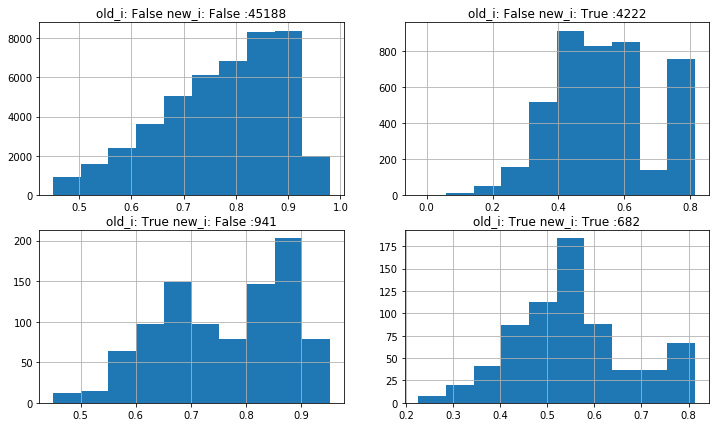

In [556]:
j=1
plt.figure(figsize=(12, 7))
for (old_i,new_i),w in merged_df1.groupby(['interdiscipilinary','new_interdiscipilinary']):
    plt.subplot(2,2,j)
    w['Similarity'].hist()
    plt.title('old_i: '+str(old_i)+' new_i: '+str(new_i)+' :'+str(len(w)) )
    j=j+1

In [353]:
merged_df1['new_interdiscipilinary'].value_counts()

False    48237
True      2796
Name: new_interdiscipilinary, dtype: int64

In [356]:
merged_df1[(merged_df1['new_interdiscipilinary']) & (merged_df1['interdiscipilinary']==False) & (merged_df1['Category']=='Life Sciences')].head(10)

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,File_Categories,Category,direct_score,ProjectURL,Topic,Top_Category,Desc_words,Similarity,interdiscipilinary,new_interdiscipilinary
196,"Bestimmung der Struktur, Dynamik und Wechselwi...",/gepris/projekt/4992156,1992,2002,Biophysics,University of Strasbourg/CNRS,Unser Ziel sind die Strukturaufklärung der C-t...,Our goal is to elucidate the structure of the ...,"Determination of the structure, dynamics and i...",elucidate terminal ion channel colicin membran...,Biophysics,Life Sciences,0.408608,https://gepris.dfg.de/gepris/projekt/4992156,16,Natural Sciences,fragment measure short solution fundamental so...,0.345473,False,True
240,Lösungsstruktur der Ran-Bindungsdomäne von Ran...,/gepris/projekt/5077246,1997,2002,Biochemistry,Universität Regensburg,Das bereits begonnene Projekt beschäftigt sich...,"The project, which has already begun, is conce...",Solution structure of the Ran binding domain o...,begin concern nuclear protein protein partner ...,Biochemistry,Life Sciences,0.532730,https://gepris.dfg.de/gepris/projekt/5077246,10,Natural Sciences,main partner concern solution domain nuclear e...,0.267883,False,True
242,Rechnerische Simulation von Operationsverfahre...,/gepris/projekt/5077364,1998,2006,Traumatology and Orthopaedics,Charité Universitätsklinikum,"(Wortlaut des Antrages)Ein detailliertes, drei...","(Full text of the proposal) A detailed, three-...",Computational simulation of surgical procedure...,proposal detailed dimensional linear lumbar sp...,Traumatology and Orthopaedics,Life Sciences,0.281933,https://gepris.dfg.de/gepris/projekt/5077364,19,Life Sciences,main mathematical extension finite load motion...,0.357959,False,True
248,Die strukturellen Voraussetzungen der beiden g...,/gepris/projekt/5077940,1997,2004,Pharmacology,Charité - Universitätsmedizin Berlin,"GLUT1 (SLC2A1), der Prototyp Glucosetransporte...","GLUT1 (SLC2A1), the prototype glucose transpor...",The structural prerequisites of the two large ...,glut1 slc2a1 prototype glucose transporter fam...,Pharmacology,Life Sciences,0.577698,https://gepris.dfg.de/gepris/projekt/5077940,16,Natural Sciences,spatial region acid importance orient essentia...,0.374289,False,True
322,Multiskalige Analyse der Ortsteingenese am Bei...,/gepris/projekt/5085426,1998,2003,Soil Sciences,Universität Hohenheim,Im Rahmen des Forschungsvorhabens 'Multiskalig...,In the framework of the research project 'Mult...,Multiscale analysis of the Ortsteingenese usin...,framework multiscale local soil engineering ex...,Soil Sciences,Life Sciences,0.174665,https://gepris.dfg.de/gepris/projekt/5085426,3,Natural Sciences,spatial integrate geometry importance engineer...,0.338957,False,True
465,Revision der Flechtenfamilie Thelotremataceae ...,/gepris/projekt/5099546,1998,2002,Evolution and Systematics of Plants and Fungi,Universität Regensburg,Während der ersten beiden Antragsjahre wurde u...,"During the first two years of application, ia....",Revision of the lichen family Thelotremataceae...,ia conduct intensive type addition african the...,Evolution and Systematics of Plants and Fungi,Life Sciences,0.337995,https://gepris.dfg.de/gepris/projekt/5099546,15,Life Sciences,region systematic center number start conduct ...,0.364982,False,True
494,Berücksichtigung der Relaxation bei Hochfreque...,/gepris/projekt/5102204,1998,2002,Radiology and Nuclear Medicine,Eberhard Karls Universität Tübingen,Im bisherigen Verlauf des DFG-Projektes wurden...,In the course of the DFG project so far method...,Consider relaxation of high-frequency pulses f...,course dfg method excitation profile frequency...,Radiology and Nuclear Medicine,Life Sciences,0.199511,https://gepris.dfg.de/gepris/projekt/5102204,10,Natural Sciences,integration extension course simulation transf...,0.303696,False,True
507,Systemische und molekulare Mechanismen tierisc...,/gepris/projekt/5103604,1998,2009,Animal Phy

In [296]:
merged_df1[(merged_df1['new_interdiscipilinary']) & (merged_df1['interdiscipilinary']==False) & (merged_df1['Category']=='Life Sciences')].head(10).Translates.tolist()

['The research programme is based on the wide variety of topics in cell and molecular biology investigated by the basic research groups in Cologne. The main areas covered include basic cell and molecular biology, neurobiology, developmental biology, immunolgy and evolution.The programme includes a number of activities intended to encourage students to critically analyse their own progress, the work of their colleagues and that of other scientists. The students are trained to give clear presentations of their experiental work, both in writing and in talks. All activities are held in English. The students organize their own seminar series in which they invite and host internationally renowned scientists. This allows them to keep up with the most exciting new developments outside their own areas of research and to establish new contacts.The programme begins with a rotation period in which students spend half a year on projects in 4 different labs chosen from among the participating groups

In [297]:
merged_df1[(merged_df1['new_interdiscipilinary']) & (merged_df1['interdiscipilinary']==False) & (merged_df1['Category']=='Life Sciences')].head(10).PreProcessedDescription.tolist()

['programme variety cell molecular biology basic cologne main area cover basic cell molecular biology neurobiology developmental biology immunolgy evolution programme number activity student analyse progress colleague student train clear presentation experiental talk activity english student seminar series invite host exciting outside area contact programme begin rotation period student half lab participate decide actual phd overview experimental valuable',
 'concentrate signal single molecule neuronal membrane membrane common single molecule protein feature share modern optical method single molecule method em ray atomic force microscopy photon microscopy conjunction patch clamp method fluorescence correlation spectroscopy dielectric spectroscopy total internal reflexion microscopy',
 'concept dimensional primary polypeptide sequence key dimensional activity protein fundamental tenet modern biochemistry dna encode sequence fold polypeptide chain essential vitality cell decade molecula

In [298]:
merged_df1[(merged_df1['new_interdiscipilinary']) & (merged_df1['interdiscipilinary']==False) & (merged_df1['Category']=='Life Sciences')].head(10).Desc_words.tolist()

['contact main progress actual analyse basic variety student biology clear series cover developmental evolution half host number period presentation valuable',
 'common single optical signal modern correlation share internal neuronal atomic force membrane microscopy spectroscopy feature fluorescence molecule total',
 'concept fundamental modern essential partial disease disorder sequence enzyme crucial primary chain decade encode dimensional',
 'combine current small molecule',
 'fragment measure short solution fundamental solid elucidate position free association channel membrane connect crystal previous orientation equilibrium presence bind measurement distance lipid characterize intermediate label relative',
 'main partner concern solution domain nuclear elucidation atomic small spectroscopy interact dimensional isotope',
 'main mathematical extension finite load motion linear distribution interface internal period calculate detailed carry element body stress force parameter compare

In [299]:
m=0
topicWord=merged_df1[(merged_df1['new_interdiscipilinary']) & (merged_df1['interdiscipilinary']==False) & (merged_df1['Category']=='Life Sciences')].head(10).Desc_words.tolist()[m]
print(topicWord)
for j in CategoryImpoWords.Category:
    CatWords=CategoryImpoWords[CategoryImpoWords.Category==j].Words.values[0]
    score=similarity_scores(topicWord, CatWords,30)
    print(j, score)

contact main progress actual analyse basic variety student biology clear series cover developmental evolution half host number period presentation valuable
Engineering Sciences 0.5765382251282256
Humanities and Social Sciences 0.6650042479636002
Life Sciences 0.4485860835188701
Natural Sciences 0.4573696330417031


## LDA Probablity based finding category

In [300]:
topic_df=pd.DataFrame(build_topics_sentences(lda_model_tfidf,corpus_tfidf))

In [301]:
merged_topic_df=topic_df.merge(TopicDesc,how='left', left_on=0, right_on='TopicNo')[[0, 1, 2, 3, 'topic_words','Category_1','Category_2']]
merged_topic_df=merged_topic_df.merge(TopicDesc,how='left', left_on=2, right_on='TopicNo')[[0, 1, 2, 3, 'topic_words_x','Category_1_x','Category_2_x','topic_words_y','Category_1_y','Category_2_y']]
merged_topic_df.columns=['Topic_1', 'Perc_cont_1', 'Topic_2', 'Perc_cont_2', 'important_topic_words_1','Category_1_1','Category_1_2', 'important_topic_words_2','Category_2_1','Category_2_2']
merged_topic_df=merged_topic_df.reset_index()[merged_topic_df.columns]

merged_df=pd.concat([df,merged_topic_df],ignore_index=True, axis=1)
merged_df.columns=df.columns.tolist()+merged_topic_df.columns.tolist()

In [302]:
merged_df['ProjectURL']=merged_df.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)

merged_df=merged_df.merge(dbdf[['ProjectURL','interdiscipilinary']],how='left', left_on='ProjectURL', right_on='ProjectURL')

In [303]:
merged_df['new_interdiscipilinary']=merged_df.apply(lambda x : x['Category']!=x['Category_1_1'],axis=1)

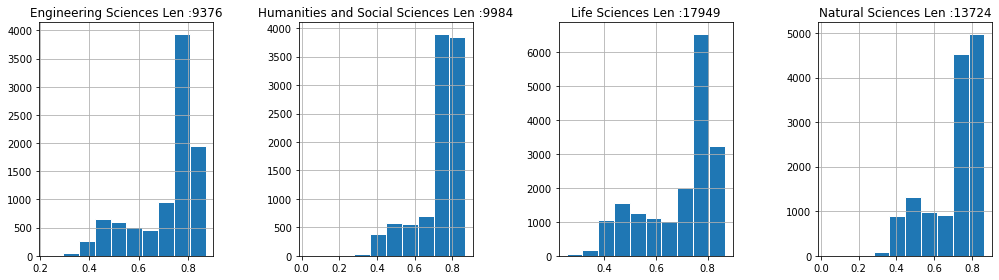

In [304]:
i=1
plt.figure(figsize=(14, 4))
for cc,w in merged_df.groupby(['Category']):
    plt.subplot(1,4,i)
    w['Perc_cont_1'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

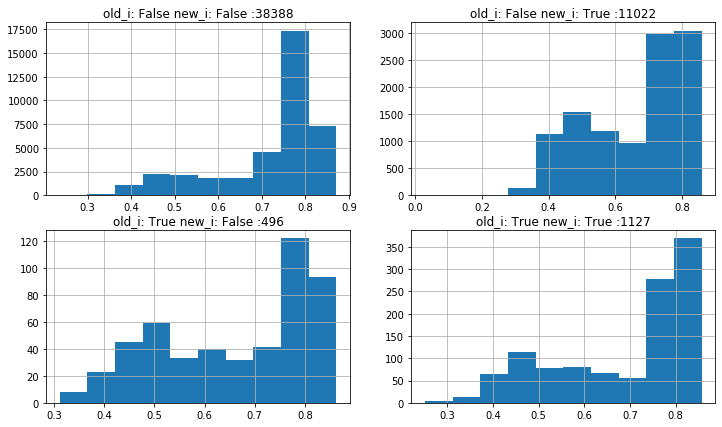

In [305]:
j=1
plt.figure(figsize=(12, 7))
for (old_i,new_i),w in merged_df.groupby(['interdiscipilinary','new_interdiscipilinary']):
    plt.subplot(2,2,j)
    w['Perc_cont_1'].hist()
    plt.title('old_i: '+str(old_i)+' new_i: '+str(new_i)+' :'+str(len(w)) )
    j=j+1

In [306]:
merged_df[(merged_df['new_interdiscipilinary']==True) & (merged_df1['Category']=='Humanities and Social Sciences')].head(10)

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,...,Topic_2,Perc_cont_2,important_topic_words_1,Category_1_1,Category_1_2,important_topic_words_2,Category_2_1,Category_2_2,interdiscipilinary,new_interdiscipilinary
67,GRK 540:&nbsp; Youth Welfare and Social Servic...,/gepris/projekt/272825,1999,2008,Educational Research,Universität Bielefeld,With the aim to draw a stronger profile in the...,With the aim to draw a stronger profile in the...,GRK 540:&nbsp; Youth Welfare and Social Servic...,draw strong profile modern welfare service tra...,...,NaN,NaN,"user, software, network, communication, servic...",Engineering Sciences,,NaN,NaN,NaN,False,True
134,"GRK 884:&nbsp; Group Focused Enmity: Causes, P...",/gepris/projekt/273603,2004,2012,Psychology,Philipps-Universität Marburg,The Research Training Group examines the preva...,The Research Training Group examines the preva...,"GRK 884:&nbsp; Group Focused Enmity: Causes, P...",examine prevalence manifestation cause consequ...,...,0.0,0.010214,"behaviour, module, switch, choice, cluster, ob...",Engineering Sciences,Natural Sciences,"mechanical, load, alloy, machine, stress, tool...",Engineering Sciences,,False,True
139,"GRK 1012:&nbsp; (Understanding, Analysing and ...",/gepris/projekt/372679,2005,2013,Economics,Freie Universität Berlin,The Research Training Group is designed to foc...,The Research Training Group is designed to foc...,"GRK 1012:&nbsp; (Understanding, Analysing and ...",design focus path dependence path path creatio...,...,NaN,NaN,"simulation, numerical, parameter, scale, defor...",Engineering Sciences,,NaN,NaN,NaN,False,True
172,GRK 1182:&nbsp; Function of Attention in Cogni...,/gepris/projekt/818604,2005,2014,Psychology,Universität Leipzig,The Research Training Group aims to investigat...,The Research Training Group aims to investigat...,GRK 1182:&nbsp; Function of Attention in Cogni...,role attention cognitive function perception i...,...,18.0,0.181049,"brain, memory, visual, neural, stimulus, cogni...",Life Sciences,,"student, school, market, child, training, educ...",Humanities and Social Sciences,,False,True
202,Kommentar zur (Lieder-)Edda,/gepris/projekt/5026167,1992,2013,Medieval German Literature,NaN,[] Von den sechs Bänden des neuen Gesamtkommen...,[] Of the six volumes of the new complete comm...,Comment to the (song) Edda,commentary page götterlieder vol heldenlieder ...,...,NaN,NaN,"theory, problem, space, algorithm, geometry, m...",Engineering Sciences,,NaN,NaN,NaN,False,True
241,Untersuchung der Beziehungen zwischen Arbeitsb...,/gepris/projekt/5077330,1997,2002,"Differential Psychology, Clinical Psychology, ...",Martin-Luther-Universität Halle-Wittenberg,Die These des 'carryover-effects' Pickering (1...,The thesis of the carryover effects Pickering ...,"Examining the relationships between workload, ...",thesis carryover psychophysiological activatio...,...,18.0,0.360642,"bone, heart, tissue, disease, animal, inflamma...",Life Sciences,,"student, school, market, child, training, educ...",Humanities and Social Sciences,,False,True
274,Probabilistisches und sensomotorisches Lernen ...,/gepris/projekt/5081281,1997,2002,"General, Biological and Mathematical Psychology",Rheinische Friedrich-Wilhelms-Universität Bonn,Viele assoziative Lernprozesse geschehen impli...,Many associative learning processes happen imp...,Probabilistic and sensorimotor learning in pat...,associative learn involvement declarative memo...,...,NaN,NaN,"brain, memory, visual, neural, stimulus, cogni...",Life Sciences,,NaN,NaN,NaN,False,True
331,Mehrdimensionale Testmodelle und deren Anwendu...,/gepris/projekt/5086062,1997,2001,"General, Biological and Mathematical Psychology",Christian-Albrechts-Universität zu Kiel,Mit der Entwicklung mehrdimensionaler Rasch-Mo...,The work groups around Mark Wilson (Berkeley a...,Multidimensional test models and their applica...,mark wilson berkeley acer eiji muraki norman m...,...,

In [307]:
merged_df[(merged_df['new_interdiscipilinary']==True) & (merged_df1['Category']=='Humanities and Social Sciences')].head(10).Translates.tolist()

["With the aim to draw a stronger profile in the structure of a modern youth welfare service, the research training group expands its main focus from three previous to four objects of research interest and will also open it for possibilities of other scientific points of view that might come with the new included petitioners. As a consequence it might be realistic to expect a brighter circle of possible scholars. The three previous objects of research included:1. The organization-related research of youth welfare service, which reconstructs the process of institutionalisation for public and free sponsors of youth welfare service and which analyses current developments of organizations';'2. The professional and personnel-related research of youth welfare service, which assesses developments in the personnel structure of youth welfare service and examines models of the competence of action at work and professional knowledge';'3. The disciplinary-related research of youth welfare service,

In [308]:
for (t1,c11,c12),w in merged_df.groupby(['Topic_1','Category_1_1','Category_1_2']):
    print(t1,c11,c12)
    print(w.Category.value_counts())

0.0 Engineering Sciences 
Engineering Sciences              2448
Natural Sciences                   220
Life Sciences                       80
Humanities and Social Sciences      11
Name: Category, dtype: int64
1.0 Natural Sciences 
Life Sciences           5
Engineering Sciences    1
Natural Sciences        1
Name: Category, dtype: int64
2.0 Other 
Humanities and Social Sciences    3
Life Sciences                     2
Natural Sciences                  1
Name: Category, dtype: int64
3.0 Natural Sciences 
Life Sciences                     576
Natural Sciences                  291
Engineering Sciences               25
Humanities and Social Sciences     10
Name: Category, dtype: int64
4.0 Life Sciences 
Life Sciences                     1075
Humanities and Social Sciences     789
Engineering Sciences               148
Natural Sciences                    30
Name: Category, dtype: int64
5.0 Life Sciences 
Life Sciences                     819
Engineering Sciences               31
Humanities

In [309]:
merged_df[['SubjectArea', 'File_Categories','Category', 'Topic_1',
       'Perc_cont_1', 'Topic_2', 'Perc_cont_2','Category_1_1','Category_1_2','Category_2_1','Category_2_2']].head()

,SubjectArea,File_Categories,Category,Topic_1,Perc_cont_1,Topic_2,Perc_cont_2,Category_1_1,Category_1_2,Category_2_1,Category_2_2
0,Mathematics,Mathematics,Natural Sciences,18.0,0.773815,NaN,NaN,Humanities and Social Sciences,,NaN,NaN
1,Social Sciences,Social Sciences,Humanities and Social Sciences,22.0,0.786946,NaN,NaN,Humanities and Social Sciences,,NaN,NaN
2,Production Technology,Production Technology,Engineering Sciences,0.0,0.440087,16.0,0.218001,Engineering Sciences,,Natural Sciences,
3,Condensed Matter Physics,Condensed Matter Physics,Natural Sciences,24.0,0.463928,10.0,0.331640,Engineering Sciences,,Natural Sciences,
4,Construction Engineering and Architecture,Construction Engineering and Architecture,Engineering Sciences,20.0,0.614565,18.0,0.229520,Engineering Sciences,,Humanities and Social Sciences,


## Combining all above methodology

In [557]:
FinalMerged=merged_df.merge(merged_df1[['ProjectURL','Desc_words','Similarity','new_interdiscipilinary']],how='left', left_on='ProjectURL', right_on='ProjectURL', suffixes=('_prob', '_dist'))

In [558]:
FinalMerged=FinalMerged.merge(df1[['ProjectURL','new_interdiscipilinary']],how='left', left_on='ProjectURL', right_on='ProjectURL', suffixes=('', '_all'))
FinalMerged['new_interdiscipilinary_all']=FinalMerged['new_interdiscipilinary']

In [559]:
FinalMerged['new_interdiscipilinary']=False
FinalMerged.loc[((FinalMerged['new_interdiscipilinary_prob']==True) & (FinalMerged['new_interdiscipilinary_dist']==True) & (FinalMerged['new_interdiscipilinary_all']==True)), 'new_interdiscipilinary']=True

In [568]:
FinalMerged['new_interdiscipilinary'].value_counts()

False    48877
True      2156
Name: new_interdiscipilinary, dtype: int64

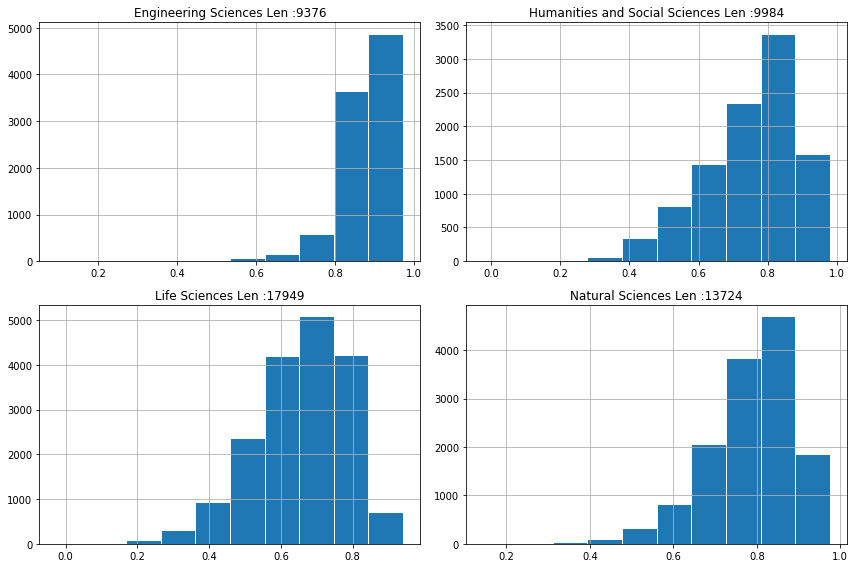

In [574]:
i=1
plt.figure(figsize=(12, 8))
for cc,w in FinalMerged.groupby(['Category']):
    plt.subplot(2,2,i)
    w['Similarity'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

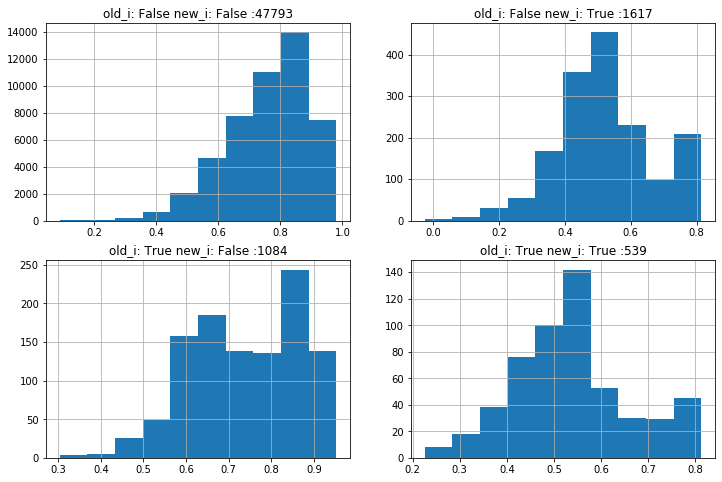

In [575]:
j=1
plt.figure(figsize=(12, 8))
for (old_i,new_i),w in FinalMerged.groupby(['interdiscipilinary','new_interdiscipilinary']):
    plt.subplot(2,2,j)
    #w['Perc_cont_1'].hist()
    w['Similarity'].hist()
    
    plt.title('old_i: '+str(old_i)+' new_i: '+str(new_i)+' :'+str(len(w)) )
    j=j+1

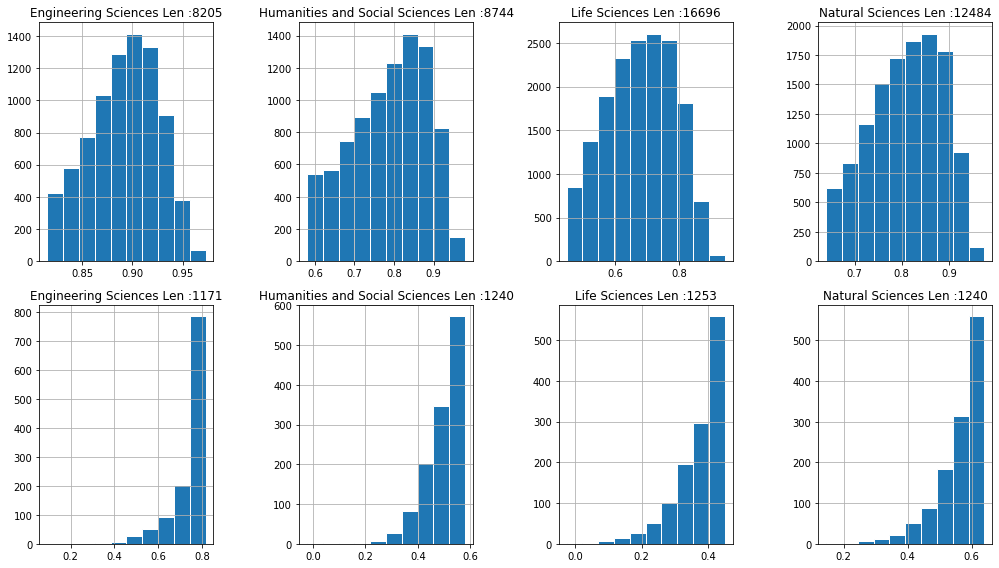

In [570]:
i=1
plt.figure(figsize=(14, 8))
for (intt,cc),w in merged_df1.groupby(['new_interdiscipilinary','Category']):
    plt.subplot(2,4,i)
    w['Similarity'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

In [562]:
FinalMerged[(FinalMerged['new_interdiscipilinary']) & (FinalMerged['interdiscipilinary']==False) & (FinalMerged['Category']=='Life Sciences')].head(10)

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,...,important_topic_words_2,Category_2_1,Category_2_2,interdiscipilinary,new_interdiscipilinary_prob,Desc_words,Similarity,new_interdiscipilinary_dist,new_interdiscipilinary,new_interdiscipilinary_all
242,Rechnerische Simulation von Operationsverfahre...,/gepris/projekt/5077364,1998,2006,Traumatology and Orthopaedics,Charité Universitätsklinikum,"(Wortlaut des Antrages)Ein detailliertes, drei...","(Full text of the proposal) A detailed, three-...",Computational simulation of surgical procedure...,proposal detailed dimensional linear lumbar sp...,...,"muscle, metabolic, metabolism, alteration, tis...",Life Sciences,,False,True,main mathematical extension finite load motion...,0.357959,True,True,True
322,Multiskalige Analyse der Ortsteingenese am Bei...,/gepris/projekt/5085426,1998,2003,Soil Sciences,Universität Hohenheim,Im Rahmen des Forschungsvorhabens 'Multiskalig...,In the framework of the research project 'Mult...,Multiscale analysis of the Ortsteingenese usin...,framework multiscale local soil engineering ex...,...,"soil, food, microbial, root, carbon, organic, ...",Natural Sciences,,False,True,spatial integrate geometry importance engineer...,0.338957,True,True,True
494,Berücksichtigung der Relaxation bei Hochfreque...,/gepris/projekt/5102204,1998,2002,Radiology and Nuclear Medicine,Eberhard Karls Universität Tübingen,Im bisherigen Verlauf des DFG-Projektes wurden...,In the course of the DFG project so far method...,Consider relaxation of high-frequency pulses f...,course dfg method excitation profile frequency...,...,NaN,NaN,NaN,False,True,integration extension course simulation transf...,0.303696,True,True,True
546,Einfluß der Humusauflage auf die Wasser- und S...,/gepris/projekt/5106524,1998,2003,Soil Sciences,Technische Universität Berlin,Auf fünf Waldstandorten in Berlin und Brandenb...,On five forest sites in Berlin and Brandenburg...,Influence of the humus layer on the water and ...,site berlin brandenburg field influence humus ...,...,"mouse, receptor, immune, disease, tumor, gene,...",Life Sciences,,False,True,chemical layer extension physical overall simu...,0.442222,True,True,True
854,Theoretische und experimentelle Untersuchungen...,/gepris/projekt/5127358,1998,2004,Plant Cultivation and Agricultural Technology,,"Es besteht das Ziel, mit Hilfe numerischer Sim...","The aim is to achieve, with the aid of numeric...",Theoretical and experimental investigations to...,aid numerical simulation mass flow core flux s...,...,NaN,NaN,NaN,False,True,solution finite evaluation numerical simulatio...,0.339110,True,True,True
1188,Mathematisch gestützte Präzisionstechniken zur...,/gepris/projekt/5150756,1999,2004,"Dentistry, Oral Surgery",Klinikum der Universität München,Ein neuartiges Vorgehen zur computergestützten...,A novel procedure for the computer-aided produ...,Mathematically supported precision techniques ...,computer aid production dental restoration cen...,...,"theory, problem, space, algorithm, geometry, m...",Engineering Sciences,,False,True,technology aspect problem mathematical measure...,0.414247,True,True,True
1282,Mathematisch gestützte Präzisionstechniken zur...,/gepris/projekt/5156212,1999,2004,"Dentistry, Oral Surgery",NaN,Ein neuartiges Vorgehen zur computergestützten...,A novel procedure for the computer-aided produ...,Mathematically supported precision techniques ...,computer aid production dental restoration cen...,...,"theory, problem, space, algorithm, geometry, m...",Engineering Sciences,,False,True,aspect problem mathematical measure optical po...,0.412912,True,True,True
1750,Fourier-Transform-Ionencyclotron-Resonanz Mass...,/gepris/projekt/5173552,1999,2004,Biochemistry,Goethe-Universität Frankfurt am Main,Die Fourier-Transform-Ionencyclotron-Resonanz ...,Fourier transform ion cyclotron resonance mass...,Fourier transform ion cyclotron resonance mass...,transform ion cyclot

In [564]:
FinalMerged[(FinalMerged['new_interdiscipilinary']) & (FinalMerged['interdiscipilinary']==False) & (FinalMerged['Category']=='Life Sciences')].head(10).Translates.tolist()

['(Full text of the proposal) A detailed, three-dimensional, non-linear lumbar spine finite element model was created to simulate various spinal surgery procedures. The stress analysis on the complex spine requires many assumptions and simplifications that can greatly affect the results. For verification, the calculation model was loaded with pure moments in the three main planes, and the intervertebral disc pressures and intersegmental motions were compared with experimentally determined data. A good match of the corresponding data could be achieved. This provides us with a mathematical model that can be expected to provide meaningful results. In the finite element model, a vertebral fixator internal, a bone chip and an implant, which serves as vertebral body replacement, were installed one after the other. At present, some very extensive parameter studies are being carried out. In the requested period we want to: a) study the influence of ventral implants on the load distribution, b)

In [565]:
FinalMerged[(FinalMerged['new_interdiscipilinary']) & (FinalMerged['interdiscipilinary']==False) & (FinalMerged['Category']=='Life Sciences')].head(10).Desc_words.tolist()

['main mathematical extension finite load motion linear distribution interface internal period calculate detailed carry element body stress force parameter compare create achieve pressure muscle dimensional good simulate pure assumption affect estimate calculation bone proposal',
 'spatial integrate geometry importance engineering flow synthesis example difference scale understand mineral microstructure origin crucial framework soil cause section site dimensional local localization record',
 'integration extension course simulation transformation equation profile spectrum case accord extent calculate optimization account excitation shape improvement previous accuracy frequency induce dimensional measurement selective request calculation hitherto pulse',
 'chemical layer extension physical overall simulation continuous degree distribution transport mineral water determination period mean resolution soil mass dependent site critical variability measurement balance inhibition record',
 's

In [576]:
FinalMerged.to_csv(Path+'LDA_Distance_Exp1.csv', index=False)